# Data Description and EDA

In [1]:
import sys
import numpy as np
import pandas as pd
import math
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import product
import sqlite3

## I. Data Description

**Million Playlist Dataset (MPD)** was created by sampling from the playlists created by Spotify users. It containsthat  information on 1,000,000 playlists (e.g. name, number of tracks, total duration...) and the songs included in those playlists (e.g. name, album, artist...).


**Million Song Dataset (MSD)** was created by the Echo Nest API and some information from a local copy
of the musicbrainz server. In particular, we used two complementary datasets: Last.fm and MusiXmatch. The former contains human labeled tags for the songs in million song dataset. The latter contains lyrics for the songs in million song dataset, represented as bag of words (BOW) that are stemmed by the Porter2 algorithm. The dictionary used for BOW consists of 5000 most frequent words in the lyrics.


**Lyrics Wiki** is a database of lyrics. There are ~2,000,000 pages each corresponding to a song, an artist, an album or a label. The lyrics of the songs are organized in 4 dimensions: artist, album, name and label, each in alphabetical order.


**Spotify Web API** returns metadata about music artists, albums, tracks directly from the Spotify data Catalogue. The information covered in the query result are similar to those covered by MSD with Spotify-specific additional information (e.g. followers for an artist, Spotify-derived audio features).

## II. Data Preprocessing

### 1. MPD

- Processed track, artist, and album IDs to get rid of unnecessary parts of the strings.
- Loaded and stored data into two dataframes, one storing information on all the playlists, and one storing information on the set of songs included in the playlists.

In [ ]:
## set up file paths
data_path = os.path.join(os.getcwd(),'millionplaylist','data')
playlist_fn = os.listdir(data_path)

## declare items that we are interested in 
pl_items_nodescription = ['name','collaborative','pid','modified_at','num_tracks',
         'num_albums','num_followers','num_edits','duration_ms','num_artists']
song_items = ['artist_name','track_name','duration_ms','album_name']
pl_df = pd.DataFrame(columns=['pid','collaborative','duration_ms',
                              'modified_at','name','num_albums',
                              'num_artists','num_edits','num_followers',
                              'num_tracks','description']) # Playlist Data
song_df = pd.DataFrame(columns=['pid','track_name','track_uri',
                                'artist_name','artist_uri',
                                'album_name','album_uri','duration_ms'])# Song Data

## run through the files
for fn in playlist_fn:
    with open(data_path+fn) as f:
        data = json.load(f)

    playlists = data['playlists']
    for playlist in playlists:
        # Playlist Data: pl_df
        try:
            pl_df = pl_df.append({item:playlist[item] for item in pl_df.columns}, 
                                 ignore_index=True)
        except KeyError: 
            pl_df = pl_df.append({item:playlist[item] for item in pl_items_nodescription}, 
                                 ignore_index=True)
        # Song Data: song_df
        pid = playlist['pid']
        for song in playlist['tracks']:            
            track_name = song['track_name']
            track_uri = song['track_uri'].split(':')[2]
            artist_name = song['artist_name']
            artist_uri = song['artist_uri'].split(':')[2]
            album_name = song['album_name']
            album_uri = song['album_uri'].split(':')[2]
            duration_ms = song['duration_ms']
            song_df = song_df.append({''}, 
                                 ignore_index=True)

## save data to csv
pl_df.to_csv('pl_df.csv')
song_df.to_csv('song_df.csv')

### 2. MSD

#### (1). Audio Features and Genres

- Extracted top genre related tags from 'Last.fm' dataset and audio features from the raw MSD dataset, and linked the two by 'track_id'.
- Saved the resulting dataframe into 'audio_tag.csv'



In [ ]:
genre_of_interest = ['rock','pop','alternative','indie','electronic',
                    'jazz','metal','soul','folk','instrumental',
                     'punk','blues','Hip-Hop']
feature_of_interest = ['danceability','energy','key','loudness','mode','tempo']

## connect to sql database
TAG_PATH  = 'lastfm_tags.db'
conn_tag  = sqlite3.connect(TAG_PATH)

## data query
sql  = """SELECT tids.tid, tags.tag, tid_tag.val FROM tid_tag, tids, tags 
          WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID 
          AND tags.tag in ('rock','pop','alternative','indie','electronic',
          'jazz','metal','soul','folk','instrumental','punk','blues','Hip-Hop')
          ORDER BY tids.tid"""
tag_data = np.array(conn_tag.execute(sql).fetchall())

## construct empty dictionary
data_dict = {track_id:{} for track_id in tag_data[:,0]}
for track_id, item in itertools.product(tag_data[:,0], feature_of_interest+genre_of_interest):
    data_dict[track_id][item] = 0
    
## fill dictionary with tag values
for entry in tag_data:
    data_dict[entry[0]][entry[1]]=float(entry[2])
    
## get file paths for songs of interest
song_data_path = os.path.join(os.getcwd(),'millionsong','data')
sub = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N',
        'O','P','Q','R','S','T','U','V','W','X','Y','Z']

song_fn = {}
for sub1, sub2, sub3 in itertools.product(sub,sub,sub):
    song_path = os.path.join(song_data_path,sub1,sub2,sub3)
    try:
        for fn in os.listdir(song_path):
            if fn.split('.')[0] in data_dict:
                song_fn[fn.split('.')[0]] = os.path.join(song_path, fn)
    except FileNotFoundError: pass
    
## read audio feature data into the dictionary
for fn in song_fn:
    s = h5py.File(song_fn[fn], 'r')
    analysis = np.array(s.get('analysis').get('songs'))[0]
    for feature in feature_of_interest:
        data_dict[fn][feature] = analysis[feature]

## turn dictionary into dataframe and drop unfound rows
data_df = pd.DataFrame.from_dict(data_dict,orient='index')
set1 = set(data_dict.keys())
set2 = set(song_fn.keys())
drop_index = list(set1 - set2)
data_df = data_df.drop(drop_index, axis=0)
data_df = data_df.drop(['danceability','energy'], axis=1)

## save data to csv
data_df.to_csv('audio_tag.csv')

#### (2). Lyrics and Emotions

- Extracted top emotion related tags from 'Last.fm' dataset and lyrics from the 'musiXmatch' dataset, and linked the two by 'track_id'.

In [3]:
"""Get the list of 5000 words used for musiXmatch's BOW representation"""
def get_mxm_vocab(conn_mxm):
    sql  = "SELECT * FROM words"
    res  = conn_mxm.execute(sql)
    data = res.fetchall()
    mxm_vocab = [t[0] for t in data]
    return mxm_vocab

In [4]:
mxm_vocab = get_mxm_vocab(conn_mxm)
mxm_dict  = {mxm_vocab[i] : i for i in range(len(mxm_vocab))}

In [5]:
"""Get the BOW regresentation of the tracks in the form of a sparse matrix"""
def get_bagofwords(tids, mxm_dict, conn_mxm):
    bows = []
    for tid in tids:
        sql  = "SELECT word, count FROM lyrics WHERE track_id='{}'".format(tid)
        res  = conn_mxm.execute(sql)
        data = res.fetchall()
        col  = np.array([mxm_dict[t[0]] for t in data], dtype=np.int16)
        row  = np.zeros(len(col),                       dtype=np.int16)
        cnt  = np.array([t[1] for t in data] )
        bow  = csr_matrix((cnt, (row, col)), shape=(1, 5000))
        bows.append(bow)
    return vstack(bows)

In [6]:
"""Get the track ids. tagged with a certain tag"""
def get_tids_oftag(tag, conn_tag):
    sql  = """SELECT tids.tid FROM tid_tag, tids, tags 
              WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID 
              AND tags.tag='{}'""".format(tag)
    res  = conn_tag.execute(sql)
    data = res.fetchall()
    return [t[0] for t in data]

In [7]:
# Get the BOW representation for tracks labelled with 'happy' and 'sad'.
happy_tids = get_tids_oftag('happy', conn_tag)
happy_bows = get_bagofwords(happy_tids, mxm_dict, conn_mxm)
sad_tids   = get_tids_oftag('sad',   conn_tag)
sad_bows   = get_bagofwords(sad_tids, mxm_dict,   conn_mxm)

### 3. Lyrics Wiki

- Scraped the title, artist and lyrics of all tracks from Lyrics Wiki.

In [1]:
from bs4 import BeautifulSoup
import requests as rq
import re
import json

In [2]:
LYRICS_WIKI_ROOT_URL = 'http://lyrics.wikia.com'

In [3]:
def scrape_one_page(one_url, alphabet, n, skip=False):
    
    one_page = rq.get(one_url)
    one_html = one_page.content
    one_soup = BeautifulSoup(one_html, 'html.parser')
    suburls = [li.find('a')['href'] 
               for li in one_soup.find_all('li', {'class': 'category-page__member'})]
    next_url = one_soup.find('a', {'class': \
               'category-page__pagination-next wds-button wds-is-secondary'})['href']
    if skip:
        return next_url
    
    
    lyric_data = []
    for song_suburl in suburls:
        try:
            song_title = one_soup.find('a', {'href': song_suburl})['title']
        except KeyError:
            continue
        song_url   = LYRICS_WIKI_ROOT_URL + song_suburl
        song_page  = rq.get(song_url)
        song_html  = song_page.content
        song_soup  = BeautifulSoup(song_html, 'html.parser')
        
        lyrics = song_soup.find('div', {'class': 'lyricbox'})
        lyric_lines = []
        try:
            for line in lyrics.contents:
                if isinstance(line, str): lyric_lines.append(line)
        except AttributeError:
            continue
        lyric_asstr = str.join('\n', lyric_lines).strip()
        lyric_data.append({'title': song_title, 'lyrics': lyric_asstr})
    
    json_fn = alphabet+'_page_'+str(n)
    with open(json_fn+'.json', 'w') as f:
        f.write(json.dumps(lyric_data))
    
    return next_url

In [4]:
def scrape_alphabet(alphabet, n_start=1, n_end=1000):
    main_page = rq.get(LYRICS_WIKI_ROOT_URL)
    main_html = main_page.content
    main_soup = BeautifulSoup(main_html, 'html.parser')
    alphabet_suburl = [a['href'] for a in 
                      main_soup.find_all('a', {'title': re.compile(r'Category:Songs.*')})]
    
    first_url = LYRICS_WIKI_ROOT_URL+alphabet_suburl[ord(alphabet)-ord('A')]
    next_url  = first_url
    for n in range(1, n_end+1):
        print(next_url, 'n={}'.format(n))
        if n < n_start:
            next_url = scrape_one_page(next_url, alphabet, n, skip=True)
        else:
            next_url = scrape_one_page(next_url, alphabet, n)

In [5]:
def show_lyrics(alphabet, page, order):
    with open(alphabet + '_page_' + str(page) + '.json', 'r') as f:
        songlist = json.loads(f.read())
    print('Title: {}'.format(songlist[order-1]['title'].split(':')[1]))
    print('Artist: {}'.format(songlist[order-1]['title'].split(':')[0]))
    print('------------------------------------------')
    print('Lyrics:')
    print(songlist[order-1]['lyrics'])

In [2]:
scrape_alphabet('Q')

### 4. Spotify Web API

- Used spotipy module to pull audio feature for all songs included in the MPD dataset.

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

## get the list of track uris we are interested in
song_df = pd.read_csv('song_df.csv')
uri_full = song_df.iloc[:,0].values
audio_dict_full = {uri:{} for uri in uri_full}

## set up authorization token for Spotify API
token = SpotifyClientCredentials(client_id='c792735e0b274108b1bb6462c1428f4f',
                                 client_secret='65fb408b80e1467a93c3f8b45ab3ebae')
sp = spotipy.Spotify(client_credentials_manager = token)

## run through the track uris to collect audio features
for k in range(0,math.floor(len(uri_full)/50)):
    print(k)
    uris = ["spotify:track:"+uri_full[i] for i in range(50*k, min(50*(k+1),len(uri_full)))]
    extracted = sp.audio_features(uris)
    for i in range(50):
        try:
            for item in ['danceability','energy','key','loudness','mode',
                        'speechiness','acousticness','instrumentalness',
                         'liveness','valence','tempo']:
                audio_dict_full[uri_full[50*k+i]][item] = extracted[i][item]
        except TypeError:
            pass

## save data to csv
MPD_audio_full = pd.DataFrame.from_dict(audio_dict_full,orient='index')
MPD_audio_full.insert(0,'track_uri',MPD_audio_full.index)
MPD_audio_full.to_csv('MPD_audio_full.csv',index=False)

## III. EDA

### 1. Basic Information on Playlists

In [2]:
def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", ' ', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [3]:
data_path = os.path.join(os.getcwd(),'millionplaylist','data')
filenames = os.listdir(data_path)

pl_lengths_list=[]
pl_followers_list=[]
pl_albums_list=[]
pl_artists_list=[]
pl_descriptions_list=[]
pl_names_list=[]

for filename in sorted(filenames):
    with open(os.path.join(data_path,filename)) as f:
        file_data = json.load(f)

    for playlist in file_data['playlists']:
        pl_lengths_list.append(playlist['num_tracks'])
        pl_followers_list.append(playlist['num_followers'])
        pl_artists_list.append(playlist['num_artists'])
        pl_albums_list.append(playlist['num_albums'])
        pl_names_list.append(normalize_name(playlist['name']))
        try: pl_descriptions_list.append(normalize_name(playlist['description']))
        except KeyError: pass

#### Number of Songs in each Playlist

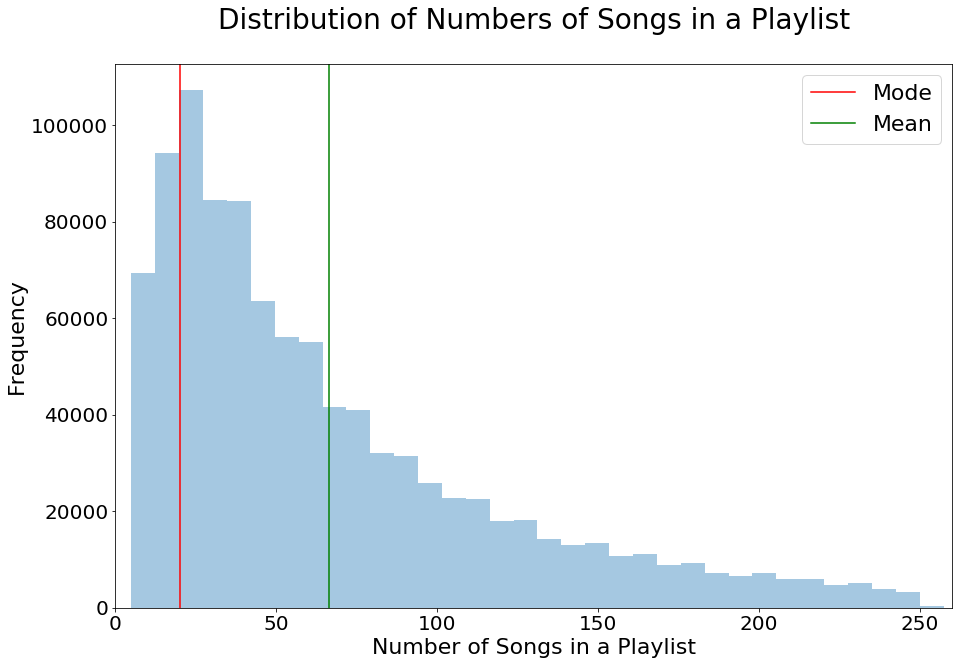

In [5]:
fig,ax = plt.subplots(1,1,figsize=[15,10])

sns.distplot(pl_lengths_list,kde=False,ax=ax)
ax.set(xlim=(0, 260))
ax.set_title('Distribution of Numbers of Songs in a Playlist',
             fontsize=28,pad=35)
ax.set_xlabel('Number of Songs in a Playlist',fontsize=22)
ax.set_ylabel('Frequency',fontsize=22)
ax.tick_params(labelsize=20)

ax.axvline(Counter(pl_lengths_list).most_common(1)[0][0],
           label='Mode',c='r')
ax.axvline(np.mean(pl_lengths_list),label='Mean',c='g')
ax.legend(fontsize=22);

#plt.savefig('num_song_pl.png')

#### Number of Artists in each Playlist

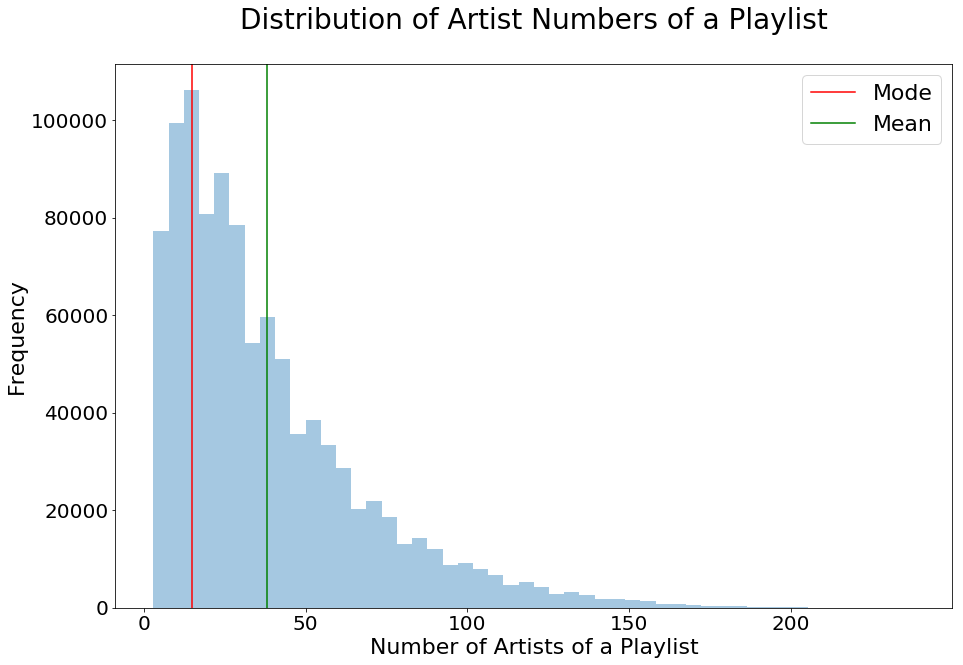

In [6]:
fig,ax = plt.subplots(1,1,figsize=[15,10])

sns.distplot(pl_artists_list,kde=False,ax=ax)
#ax.set(xlim=(0, 260))
ax.set_title('Distribution of Artist Numbers of a Playlist',
             fontsize=28,pad=35)
ax.set_xlabel('Number of Artists of a Playlist',fontsize=22)
ax.set_ylabel('Frequency',fontsize=22)
ax.tick_params(labelsize=20)

ax.axvline(Counter(pl_artists_list).most_common(1)[0][0],
           label='Mode',c='r')
ax.axvline(np.mean(pl_artists_list),label='Mean',c='g')
ax.legend(fontsize=22);

#### Number of Albums in each Playlist

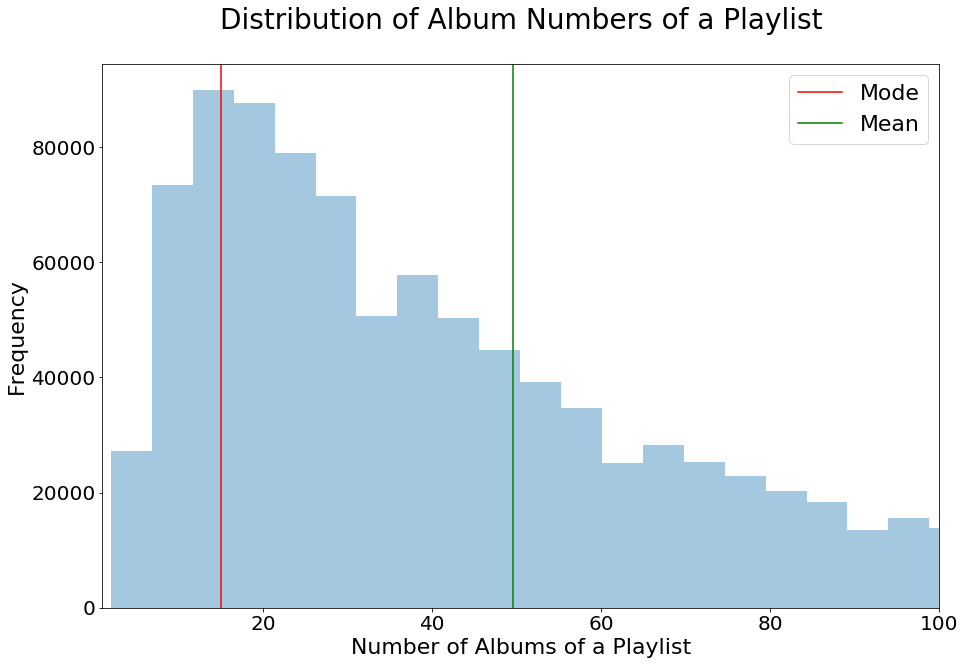

In [7]:
fig,ax = plt.subplots(1,1,figsize=[15,10])

sns.distplot(pl_albums_list,kde=False,ax=ax)
ax.set(xlim=(1,100))
ax.set_title('Distribution of Album Numbers of a Playlist',
             fontsize=28,pad=35)
ax.set_xlabel('Number of Albums of a Playlist',fontsize=22)
ax.set_ylabel('Frequency',fontsize=22)
ax.tick_params(labelsize=20)

ax.axvline(Counter(pl_albums_list).most_common(1)[0][0],
           label='Mode',c='r')
ax.axvline(np.mean(pl_albums_list),label='Mean',c='g')
ax.legend(fontsize=22);

#### Popular Playlist Names

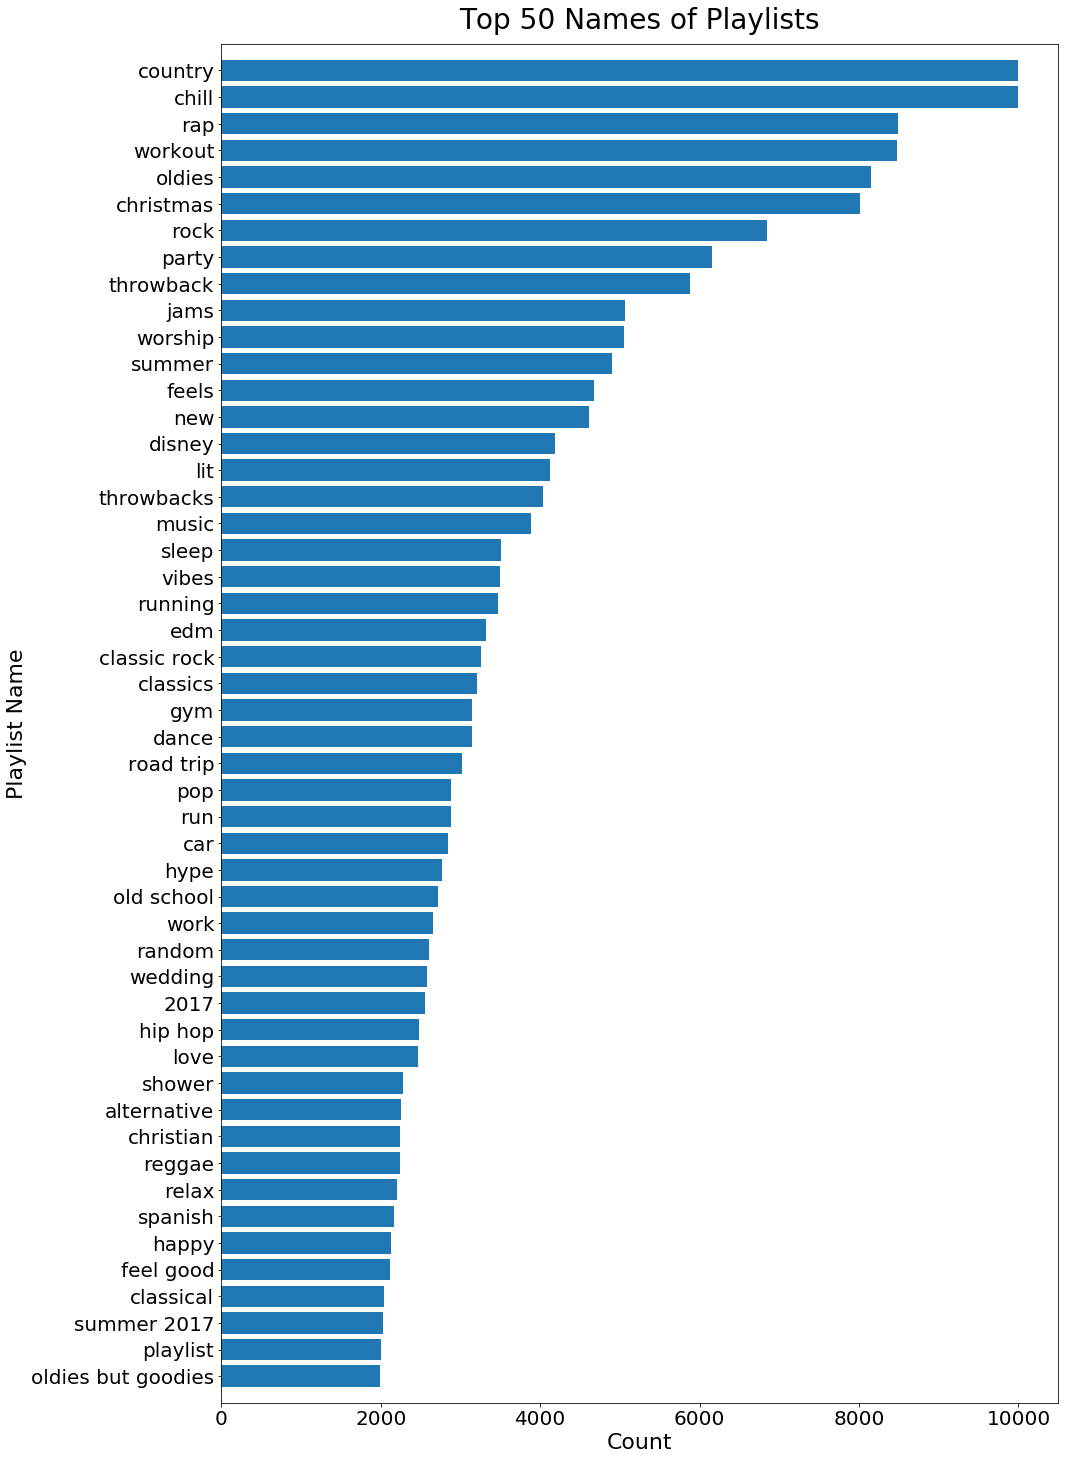

In [9]:
plname_count_df = pd.DataFrame(Counter(pl_names_list).most_common(50))
plname_count_df.columns = ['name','count']

fig,ax = plt.subplots(1,1,figsize=[15,25])

ax.barh(plname_count_df['name'][:50],plname_count_df['count'][:50])
ax.set_title('Top 50 Names of Playlists',fontsize=28,pad=15)
ax.set_xlabel('Count',fontsize=22)
ax.set_ylabel('Playlist Name',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylim([-1,50])
ax.invert_yaxis();


#### Popular Playlist Descriptions

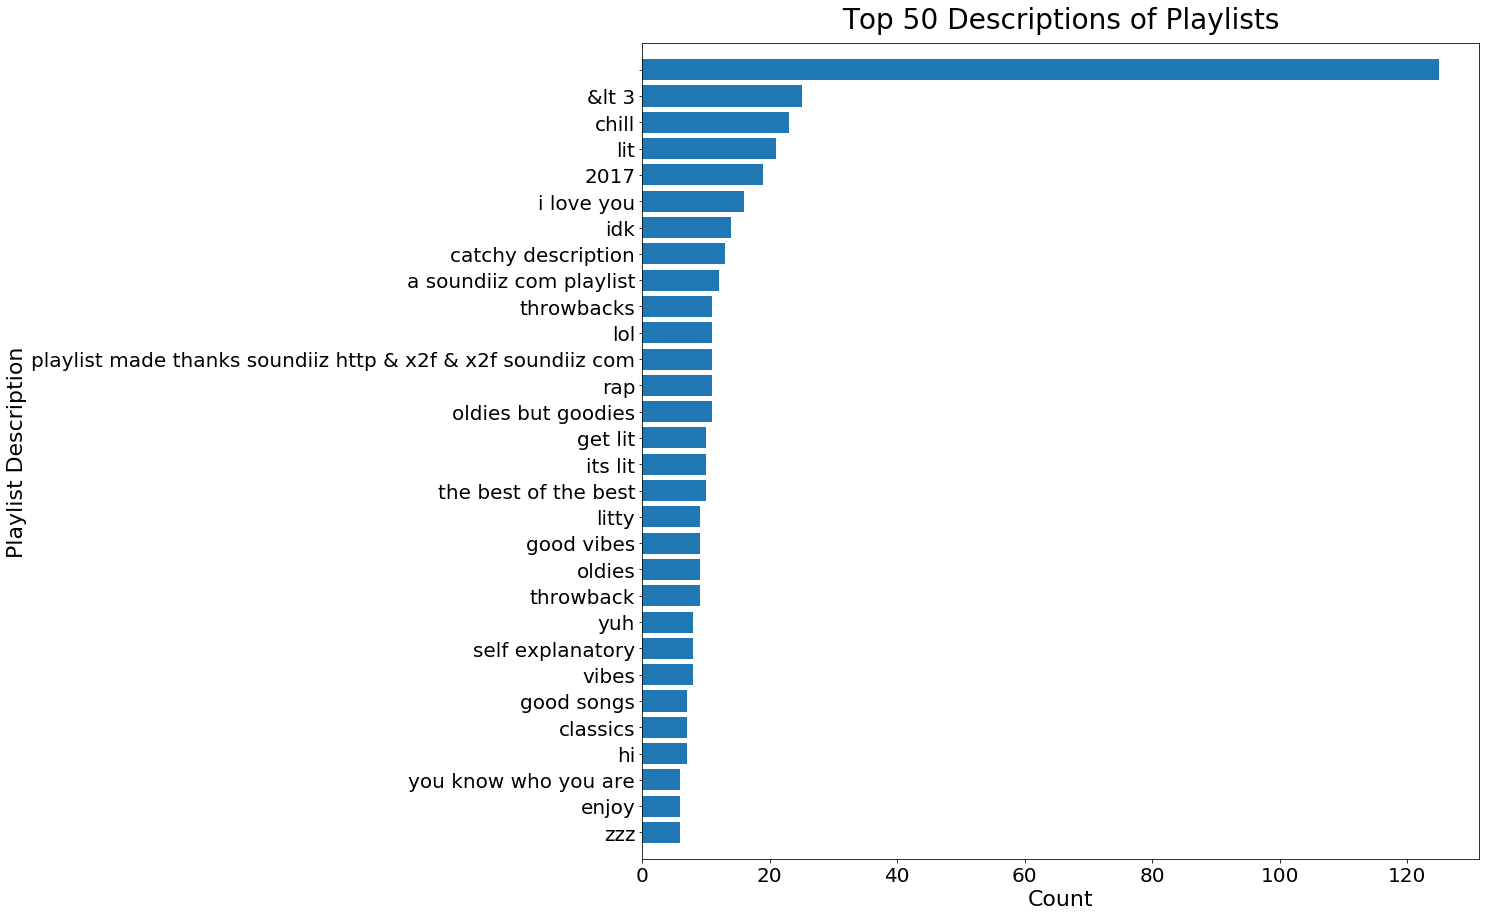

In [10]:
pldesc_count_df = pd.DataFrame(Counter(pl_descriptions_list).most_common(30))
pldesc_count_df.columns = ['desc','count']

fig,ax = plt.subplots(1,1,figsize=[15,15])

ax.barh(pldesc_count_df['desc'][:30],pldesc_count_df['count'][:30])
ax.set_title('Top 50 Descriptions of Playlists',fontsize=28,pad=15)
ax.set_xlabel('Count',fontsize=22)
ax.set_ylabel('Playlist Description',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylim([-1,30])
ax.invert_yaxis();


We found that the numbers of songs, albums, and artisits in playlists are all right skewed, which is expected. These insights give us a better idea in terms of how many songs to recommend, and how diverse a common playlist is.

Moreover, we found that playlist names are more complete and informative than playlist descriptions. Therefore, when we try to combine playlists, we will use playlist names as the criterion.

### 2. Number of Songs under each Playlist Name

In [11]:
with open("CF_matrix_condensed.json", "r") as f:
    matrix_data = json.load(f)

title_lengths = Counter()


In [ ]:
data_path = os.path.join(os.getcwd(),'millionplaylist','data')
filenames = os.listdir(data_path)

name_count = Counter()

for filename in sorted(filenames):
    with open(os.path.join(data_path,filename)) as f:
        file_data = json.load(f)

    for playlist in file_data['playlists']:
        name_norm = normalize_name(playlist['name'])
        name_count[name_norm] += 1

name_song_dict = {name:set() for name in name_count}

progress_count = 0
for filename in filenames:
    with open(os.path.join(data_path,filename)) as f:
        file_data = json.load(f)
    
    for playlist in file_data['playlists']:
        progress_count += 1
        print(progress_count)
        name_norm = normalize_name(playlist['name'])
        for song in playlist['tracks']:
            name_song_dict[name_norm].add(song['track_uri'].split(':')[2])

In [13]:
X_plot = []
Y_plot = []

for name in name_count:
    X_plot.append(name_count[name])
    Y_plot.append(len(name_song_dict[name]))

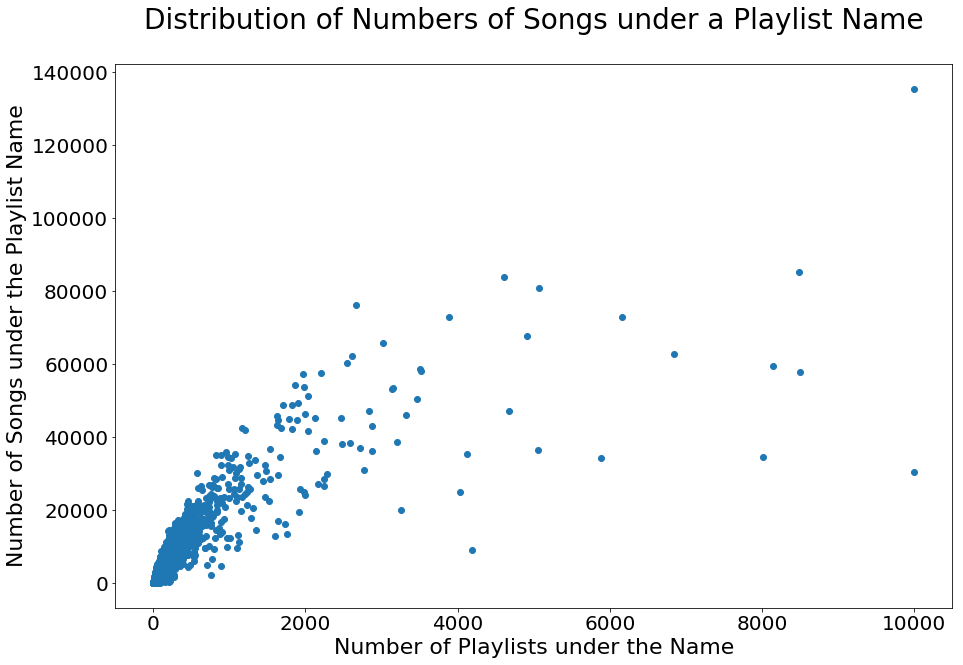

In [14]:
fig,ax = plt.subplots(1,1,figsize=[15,10])

ax.scatter(X_plot,Y_plot)
ax.set_title('Distribution of Numbers of Songs under a Playlist Name',
             fontsize=28,pad=35)
ax.set_xlabel('Number of Playlists under the Name',fontsize=22)
ax.set_ylabel('Number of Songs under the Playlist Name',fontsize=22)
ax.tick_params(labelsize=20);

#plt.savefig('num_song_title.png')

We observe that when the number of playlists under the same name is small, there is a positive linear relationship between the number of songs and the number of playlists. However, as the number of playlists grows, except ‘chill’, most playlist names do not have more than 80,000 songs under them. This is to say, a lot of songs are repeated in multiple playlists with the same theme. This allows us to have a richer scoring record if we were to treat each playlist name as a user with a distinct taste, and the number of occurrences of each song to represent the degree of preference.

### 3. Popular Tags in Last.fm

In [ ]:
data_paths = [os.path.join(os.getcwd(),'lastfm_train'),
              os.path.join(os.getcwd(),'lastfm_test')]
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
            'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
progress_count=0
tag_count=Counter()
for data_path,a,b,c in product(data_paths,alphabet,alphabet,alphabet):
    path = os.path.join(data_path,a,b,c)
    try:
        filenames = os.listdir(path)
        for filename in sorted(filenames):
            with open(os.path.join(path,filename)) as f:
                file_data = json.load(f)
            progress_count+=1
            print(progress_count)
            for tag in file_data['tags']:
                tag_count[tag[0]] += 1
    except FileNotFoundError:
        pass
    

In [16]:
tag_count_df = pd.DataFrame(tag_count.most_common(50))
tag_count_df.columns = ['tag','count']
tag_count_df['type'] = 'other'
index_genre = [0,1,2,3,4,10,11,14,18,19,20,22,24,29,30,33,34,43]
index_mood = [15,21,27,45]
index_time = [9,23,26,44]
tag_count_df.iloc[index_genre,2] = 'genre'
tag_count_df.iloc[index_mood,2] = 'mood'
tag_count_df.iloc[index_time,2] = 'decade'
tag_count_df

,tag,count,type
0,rock,101071,genre
1,pop,69159,genre
2,alternative,55777,genre
3,indie,48175,genre
4,electronic,46270,genre
5,female vocalists,42565,other
6,favorites,39921,other
7,Love,34901,other
8,dance,33618,other
9,00s,31432,decade


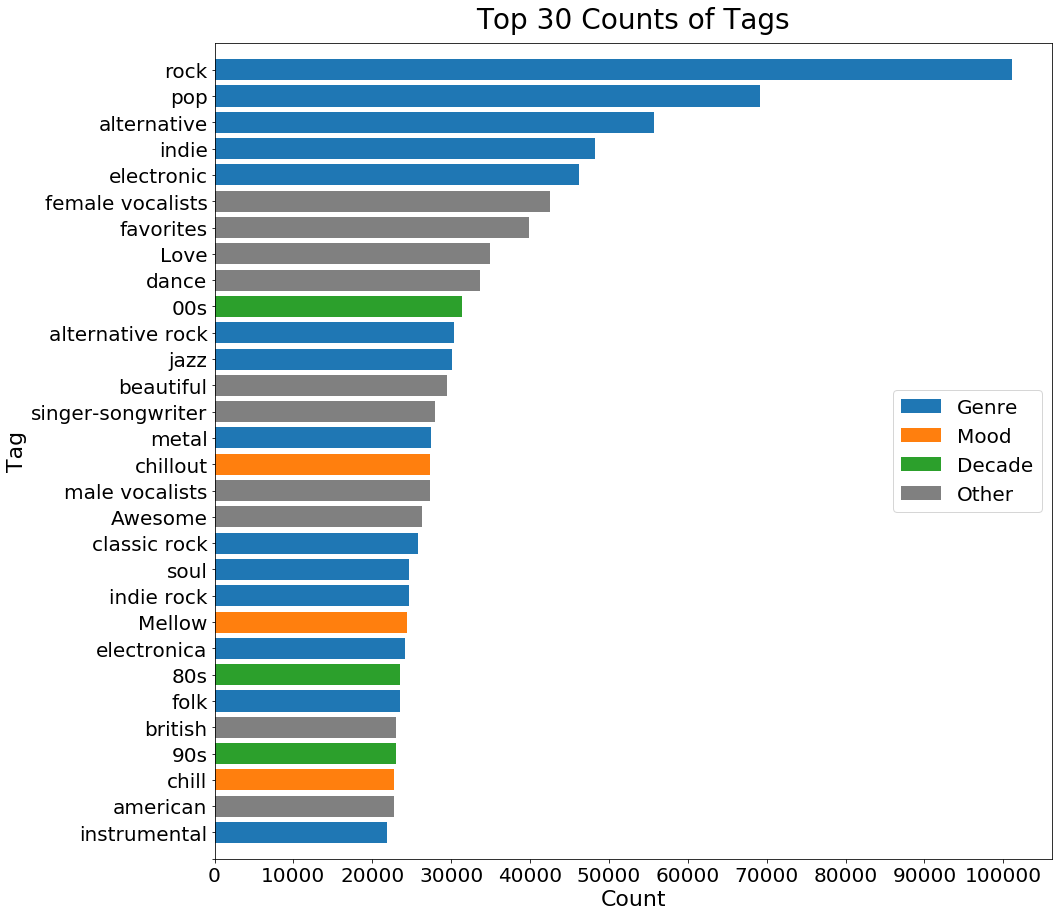

In [17]:
colors = ['grey']*50
for i in index_genre: colors[i] = sns.color_palette()[0]
for i in index_mood: colors[i] = sns.color_palette()[1]
for i in index_time: colors[i] = sns.color_palette()[2]

fig,ax = plt.subplots(1,1,figsize=[15,15])

ax.barh(tag_count_df['tag'][:30],tag_count_df['count'][:30],
        color=colors[:30],label='Genre')
ax.barh('','',color=sns.color_palette()[1],label='Mood')
ax.barh('','',color=sns.color_palette()[2],label='Decade')
ax.barh('','',color='grey',label='Other')
ax.set_title('Top 30 Counts of Tags',fontsize=28,pad=15)
ax.set_xlabel('Count',fontsize=22)
ax.set_ylabel('Tag',fontsize=22)
ax.tick_params(labelsize=20)
plt.xticks(ticks=np.arange(0,110000,10000),
           labels=np.arange(0,110000,10000))

ax.set_ylim([-1,30])
ax.invert_yaxis()
ax.legend(fontsize=20,loc='center right');

#plt.savefig('tag_count.png',bbox_inches = 'tight')

We see that more than half of the tags indicate either the genre, emotion, or decade of the songs. Intuitively, the decade is hard to predict. Therefore, we will focus on using lyrics to identify emotion, and using sound feature to identify genre in our music recommendation model.

### 4. Linking MPD and MSD

In [ ]:
data_paths = [os.path.join(os.getcwd(),'lastfm_train'),
              os.path.join(os.getcwd(),'lastfm_test')]
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
            'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
song_count_lastfm=0
artist_title_lastfm = set()
for data_path,a,b,c in product(data_paths,alphabet,alphabet,alphabet):
    path = os.path.join(data_path,a,b,c)
    try:
        filenames = os.listdir(path)
        for filename in filenames:
            with open(os.path.join(path,filename)) as f:
                file_data = json.load(f)
            song_count_lastfm+=1
            print(song_count_lastfm)
            artist_title_lastfm.add((file_data['artist'],file_data['title']))
    except FileNotFoundError:
        pass

In [19]:
artist_title_MPD = set()
song_df = pd.read_csv('song_df.csv',index_col=0)
for artist,title in zip(song_df['artist_name'],song_df['track_name']):
    artist_title_MPD.add((artist,title))

In [20]:
distinct_song_count_lastfm = len(artist_title_lastfm)
repeated_lastfm = song_count_lastfm - distinct_song_count_lastfm

song_count_MPD = len(song_df)
distinct_song_count_MPD = len(artist_title_MPD)
repeated_MPD = song_count_MPD - distinct_song_count_MPD

In [21]:
contained = 0
for pair in artist_title_MPD:
    if pair in artist_title_lastfm:
        contained += 1

In [22]:
print('# Repeated <artist - song name> pair in MPD: ',repeated_MPD)
print('# Repeated <artist - song name> pair in MSD: ',repeated_lastfm)
print('# Overlapped <artist - song name> pair in MPD and MSD: ',contained)

# Repeated <artist - song name> pair in MPD:  72593
# Repeated <artist - song name> pair in MSD:  82274
# Overlapped <artist - song name> pair in MPD and MSD:  144300


From previous EDA, we learned that there are around 1,000,000 songs in MSD and around 2,200,000 songs in MPD. However, if we consider the 'artist - song name' pair as an indication of a distinct song, each dataset contains over 70,000 repeated songs, and there are only 144,300 songs repeated in both datasets. We need to find better ways to link the two datasets and build a comprehensive MRS.